# Learning better data representations for AI with Scikit-Learn and Keras

## James McDermott, Lecturer in Computer Science, NUI Galway

## james.mcdermott@nuigalway.ie

## `@bleepbeepbzzz`


# Introduction

### This notebook/presentation is about learning representations (embeddings) for data using classic machine learning methods, and also using a modern method (a Siamese neural network with triplet loss). It is part of the Atlantec 2019 AI Tools and Techniques session.

### We won't assume any prior knowledge, but will assume willingness to ignore unnecessary details :) Some knowledge of Python, Numpy, and neural networks is helpful.

# About me

James McDermott is a Lecturer in Computer Science in the National University of Ireland, Galway, where he teaches courses in the area of artificial intelligence. He holds a BSc in Computer Science with Mathematics from the National University of Ireland, Galway, and a PhD in evolutionary computation and computer music from the University of Limerick. He has also worked on supercomputing in Compaq/Hewlett-Packard. His post-doctoral work was in evolutionary design and genetic programming in University College Dublin and Massachusetts Institute of Technology. His research interests are in program synthesis, evolutionary computing, artificial intelligence, and computational music and design. He has chaired the EuroGP and EvoMUSART international conferences and is a member of the Genetic Programming and Evolvable Machines journal editorial board. 


# Installation/setup

## (Recommended): visit https://tinyurl.com/atlantec-jmmcd


(That URL will redirect to a Google Colab notebook: https://colab.research.google.com/github/jmmcd/ML-snippets/blob/master/Representations_for_AI/Representations_for_AI.ipynb)

* (Advanced alternative): if you know how to clone from Github and run a Jupyter notebook, then instead you can clone this notebook from: https://github.com/jmmcd/ML-snippets (it's in the `Representations_for_AI` directory) and run it locally.


## AI in the past, present and future (approximately)



* Around 45 years ago, statistical learning (think: regression) was already successful on some tasks. But in the AI world the focus was mostly on "good old-fashioned AI", that is symbolic approaches driven by rules, planning, world-modelling.

* Around 35 years ago, neural/connectionist approaches got a lot of hype, and succeeded on some tasks, but failed to deliver on some more ambitious goals, leading to an "AI Winter". Example: Multi-Layer Perceptron.

* Around 25 years ago, other statistical learning approaches came along and neural approaches went out of fashion. We started to see that a good general approach to data problems was to see how to map the data from one space into another which better reflects the true "geometry" of the data -- ie make an *embedding* of the data -- and to base our algorithms on *distances* between data points in the new space. Example: Support Vector Machines.


* Around 10 years ago, we finally understood how to make *deep* (many-layer) neural networks succeed, especially on vision tasks. Example: AlexNet, a Deep Convolutional Neural Network. It turned out that what they were doing internally and implicitly was something a lot like *learning good embeddings from the data*. Each layer in a deep neural network maps the data into a new space, slightly rearranging it.

<img src="img/NeuralNetwork.png" width=600 alt="Image of a small feedforward neural network"> <font size=1>[source Wikimedia]</font>

* Now, we are seeing several approaches which do the same task deliberately. Examples: Word2Vec, Generative Adversarial Networks and Variational Auto-encoders. 

* We are also seeing neural networks taking on tasks such as time-series modelling, speech recognition, game-playing. Examples: Long Short-Term Memory and Reinforcement Learning.


* In the future, I think that we'll come full circle, and we'll see symbolic approaches layered on top of these learned embeddings. For example, the system will learn an embedding using techniques like what we'll see today, and then produce an explicit symbolic representation of the implicitly-learned embedding. That will enable reasoning, explanation (and human-style reasoning is a lot like explaining), and robustness -- properties that are lacking in current neural approaches.

# Our goal today is 
### (1) to develop an intuition for embeddings, and so understand a core underlying mechanism of AI 
### (2) learn some of the APIs of Scikit-learn for machine learning and Keras for deep learning.

# What is an embedding?

### An embedding is a mapping from an original data space to a new space, usually of lower dimension. For our purposes, in a *good* embedding the geometry of the new space reflects some properties of the data.

<img src="img/word_embedding.png" width=600 alt="Example of a word embedding"> <font size=1>[source mathworks.com]</font>

## Regression: predict a real number, eg house price

## Classification: predict a label, eg 0/1 (cat/dog)

## *Embedding*: output a real vector, interpreted as a location

<img src="img/king-queen.png" width="600"> <font size=1>[source https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e]</font>


# Singular - Plural

<img src="img/plural-relation.png" width=600> <font size=1>[source https://www.kdnuggets.com/2016/05/amazing-power-word-vectors.html]</font>



## Import all the usual libraries and tell Matplotlib to show plots in the notebook

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.base import TransformerMixin
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D, Input, Lambda
from keras.utils import np_utils, plot_model
from keras.datasets import mnist
from keras import backend as K

Using TensorFlow backend.



## Load and re-shape data

In [3]:
# Tensorflow provides the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Each digit is of shape 28x28 with just 1 channel (greyscale, not RGB)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32') # convert to float
X_test = X_test.astype('float32')
X_train /= 255 # scale to the range [0, 1]
X_test /= 255

## Let's look at some sample images

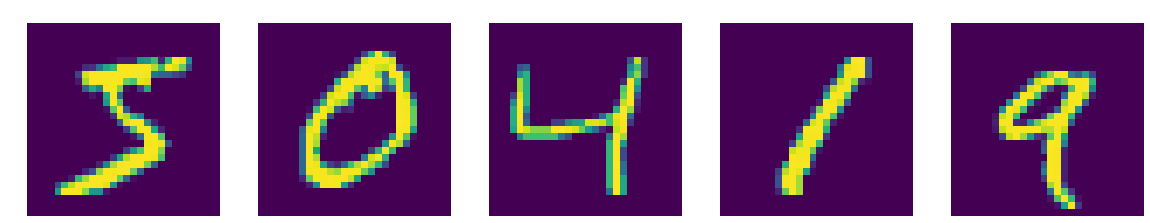

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 100))
for i, ax in enumerate(axs.flat):
    ax.matshow(X_train[i].reshape(28, 28))
    ax.axis('off')

# Visualisation: how are the digits distributed in the embedding?

In [23]:
def make_viz(xy, ims):
    """Generate an image of our embedding. xy is an array of x-y coordinates of the data
    points, and ims are the data points themselves (the original images)."""
    canvas_size = 1500
    imsize = ims[0].shape
    canvas = np.zeros((canvas_size+imsize[0], canvas_size+imsize[1]), dtype=float)
    pts = loc2pix(xy, canvas_size) # scale to fit canvas
    for p, im in zip(pts, ims):       
        # paint the image of the digit onto the canvas
        canvas[p[0]:p[0]+imsize[0], p[1]:p[1]+imsize[1]] = im[:, :]

    # 20x20 inches: we have to make it large to avoid subsampling
    fig, ax = plt.subplots(figsize=(20, 20)) 
    ax.matshow(canvas)
    plt.show()

In [24]:
def loc2pix(x, size):
    """Helper function for make_viz. All values in x are in some range [min, max], and 
    we want it in [0, size]."""
    x = (x - x.min()) / (x.max() - x.min()) # now in [0, 1]
    x *= size
    x = x.astype(int)
    assert np.all(x >= 0) and np.all(x <= size)
    return x

# Classic algorithms for embedding

## Multi-dimensional scaling (MDS)

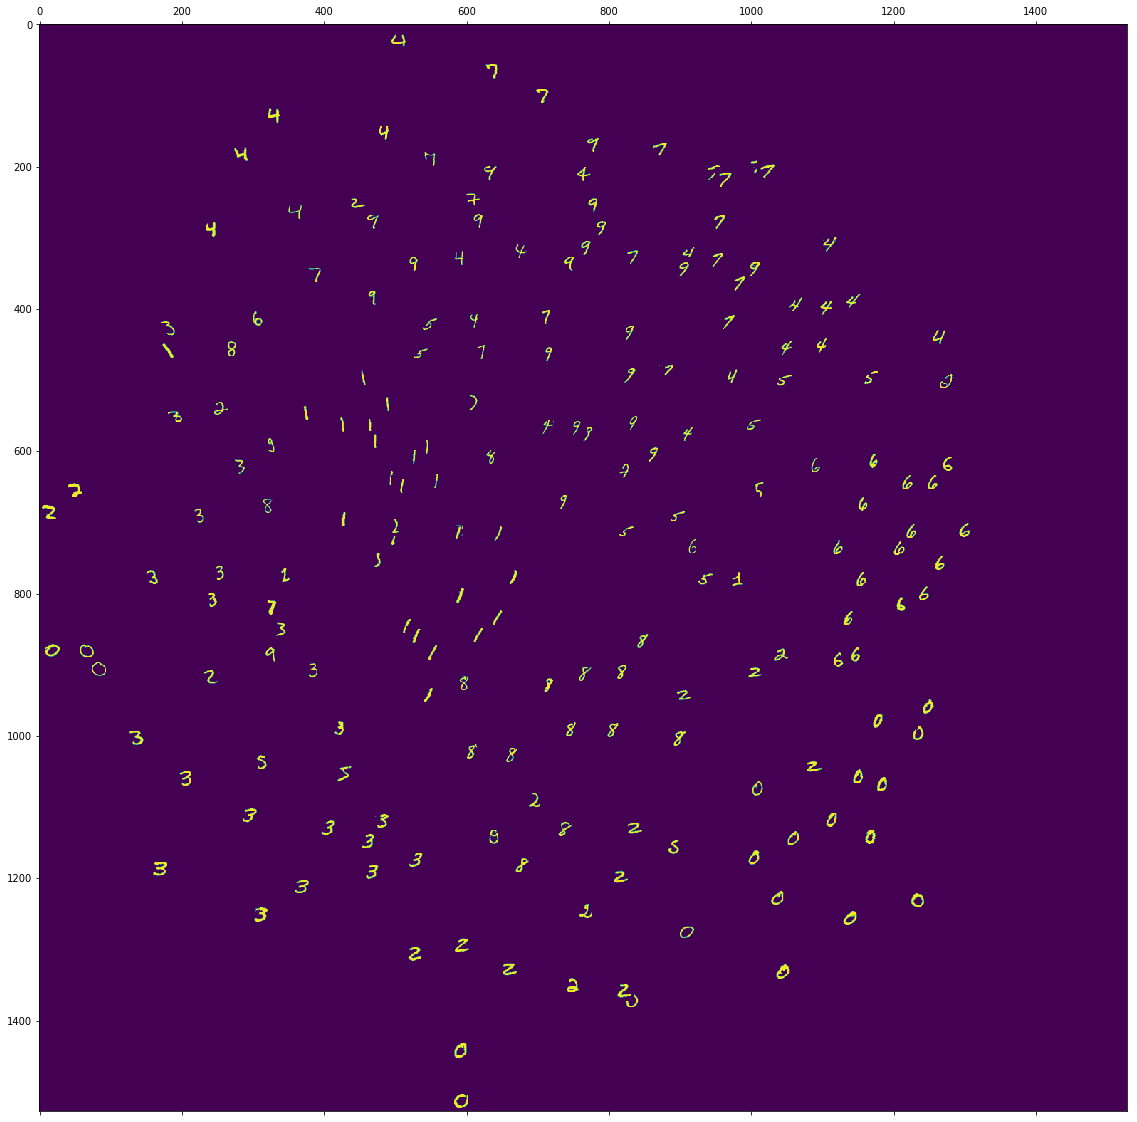

In [34]:
n_samples_train = n_samples_test = 200

mds = MDS(n_components=2) # fit_transform()
x = mds.fit_transform(X_train[:n_samples_train].reshape(n_samples_train, 28*28))
make_viz(x, X_train[:n_samples_test].squeeze())

## Principal components analysis (PCA)


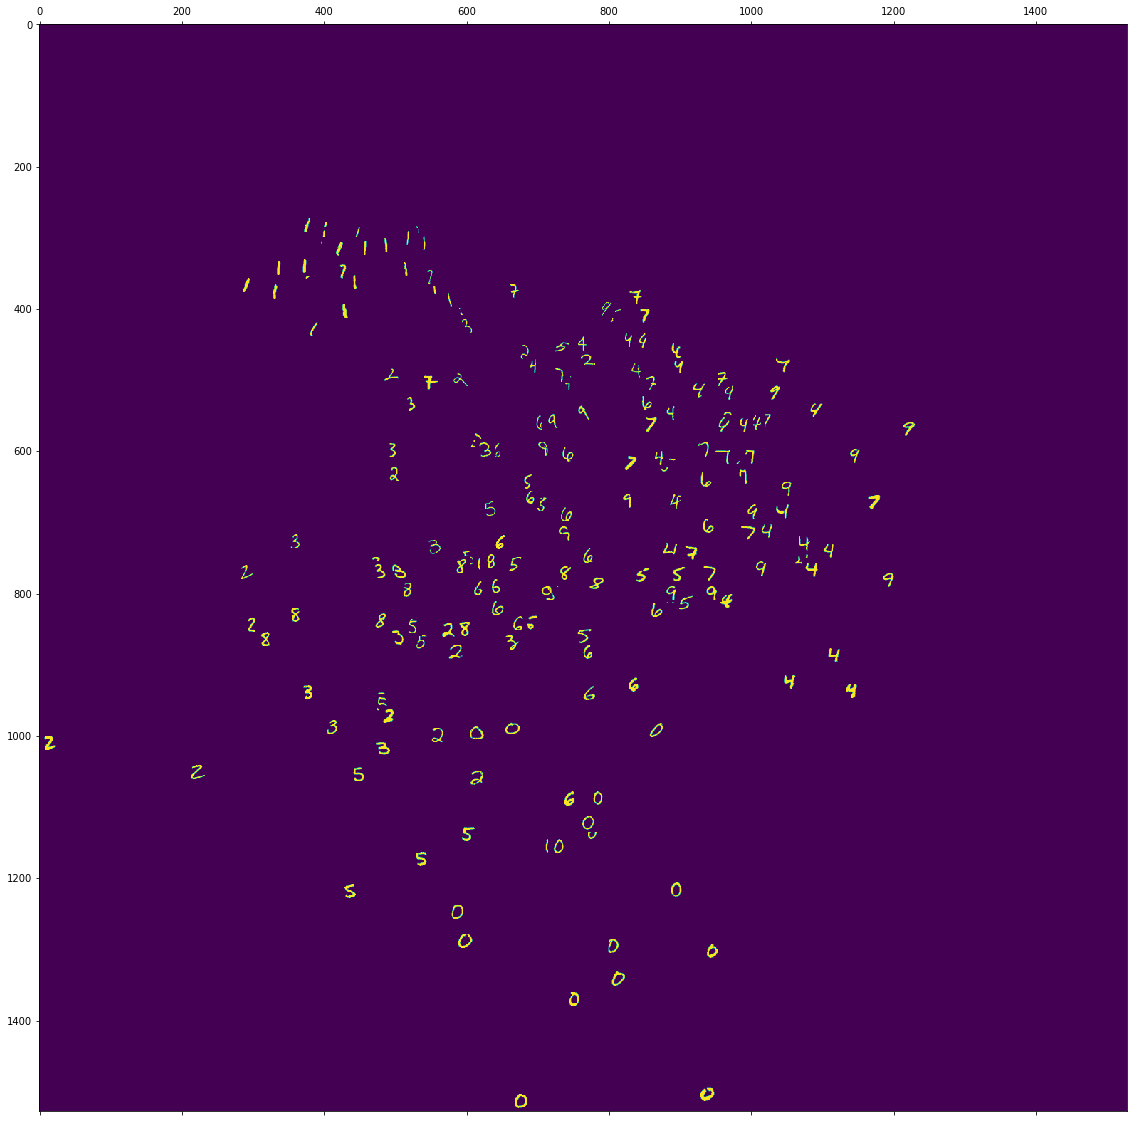

In [26]:
pca = PCA(n_components=2) # fit() and then transform()
pca.fit(X_train[:n_samples_train].reshape(n_samples_train, 28*28))
x = pca.transform(X_test[:n_samples_test].reshape(n_samples_test, 28*28))
make_viz(x, X_test[:n_samples_test].squeeze())

# Results are good!

* We already have a useful embedding. Other algorithms (clustering, anomaly detection, classification, visualisation, interactive search...) can be expected to work well using that embedding.


# Notice that the `scikit-learn` API is consistent.
### Very easy to swap out one algorithm for another.

```python
mds = MDS()
mds.fit_transform(X)
tsne = TNSE() # t-SNE, another algorithm doing a similar job
tsne.fit_transform(X)
```


<img src="img/Data_Science_VD.png" width=600 alt="Data Science Venn Diagram by Drew Conway">
<font size=1>[source http://drewconway.com/zia/2013/3/26/the-data-science-venn-diagram</font>





# Next, we are going to train a deep convolutional neural network to do the same task.

* We will use Keras
* We will mimic the Scikit-learn API

### Convolutional: suitable for images. Each neuron "looks at" each patch of the input in succession and outputs a new "image"

### Siamese network: we run our convolutional network multiple times on different images, and then...

### Triplet loss: ... we ask it to "push" similar images closer together, and push distinct images farther apart.

<img src=img/siamese.png alt="Smiley face" height="800" width="800">

Triplet-loss and model source: https://github.com/Ao-Lee/Shares/blob/master/triplet%20inputs.py

Adapted by James McDermott:
 - changed to MNIST task
 - changed to a small, simple network (not ResNet)
 - added generation of proper a, p, n triplets
 - increased alpha to try to prevent the embedding from winning trivially
 - removed the L2 normalisation (pushing all digits to surface of hypersphere)
 - added a 2D layout visualisation of our embedding

Next up is the complete code for the `SiameseConvEmbedding` neural network. We won't read through this in full but will pick out highlights after.

In [44]:
class SiameseConvEmbedding(TransformerMixin): # inherit from sklearn TransformerMixin
    def __init__(self, n_components=2, 
                 learning_rate=0.001, batch_size=100, 
                 epochs=5, alpha=0.4):
        self.n_components = n_components
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.alpha = alpha
        
    def __repr__(self):
        return f"""SiameseConvEmbedding(n_components={self.n_components}, 
learning_rate={self.learning_rate}, 
batch_size={self.batch_size},
epochs={self.epochs},
alpha={self.alpha})"""
        
    def get_image(self, label, X, y):
        """Choose an image from our training or test data with the
        given label."""
        idx = np.random.randint(len(y))
        while y[idx] != label:
            # keep searching randomly
            idx = np.random.randint(len(y))
        return X[idx] 
        
    def get_triplet(self, X, y):
        """Choose a triplet (anchor, positive, negative) of images
        such that anchor and positive have the same label and
        anchor and negative have different labels."""
        n = a = np.random.choice(self.labels)
        while n == a:
            # keep searching randomly
            n = np.random.choice(self.labels)
        A = self.get_image(a, X, y)
        P = self.get_image(a, X, y) # get two images of same label for A and P
        N = self.get_image(n, X, y) # get image of a different label for N
        return A, P, N

    def generate_triplets(self, X, y):
        """Generate an un-ending stream (using yield) of triplets for
        training."""
        while True:
            A = np.zeros((self.batch_size, *self.imsize))
            P = np.zeros((self.batch_size, *self.imsize))
            N = np.zeros((self.batch_size, *self.imsize))

            for i in range(self.batch_size):
                A[i], P[i], N[i] = self.get_triplet(X, y)

            # a "dummy" label which will come in to our identity loss
            # function below as y_true. We'll ignore it.
            label = np.ones(self.batch_size) 
            yield [A, P, N], label
        
    ############## Loss ###########################

    def identity_loss(self, y_true, y_pred):
        """This loss function just takes the mean of y_pred. Because of the
        way we wire the network (see complete_model below), y_pred is the
        output of the triplet loss, so minimising it is what we want to
        do."""
        return K.mean(y_pred)

    def triplet_loss(self, x):
        """The triplet loss is ||A - P|| - ||A - N|| + alpha, where ||.||
        is the Euclidean norm. Notice that this is not a loss function in the
        format expected by Keras, ie f(y_true, y_pred)."""
    
        anchor, positive, negative = x
        # axis=1 because here we are summing along the dimensions of the embedding
        A_P = K.sqrt(K.sum(K.square(anchor - positive), axis=1))
        A_N = K.sqrt(K.sum(K.square(anchor - negative), axis=1))
        loss = K.maximum(A_P - A_N + self.alpha, 0)
        return loss # this is a vector, 1 value per triplet

    
    ############## Model ###########################

    def embedding_model(self):
        """A tiny vision model. Its input is an image and output is an embedding.  We
        don't compile or add a loss here since this will become a component in
        the complete model below."""
        model = Sequential()
        model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=self.imsize))
        model.add(Convolution2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.25))
        model.add(Flatten())
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.n_components, activation='tanh'))
        return model


    def complete_model(self):
        """This part of the model is quite tricky. Rather than a Sequential
        model, we declare a Model and say which are its inputs and
        outputs, and we declare how the outputs are calculated from the
        inputs. In particular, there are no layers in this model, other
        than the layers in the embedding model discussed above.

        A further complication is that our triplet loss can't be
        calculated as a function of y_true and y_predicted as
        usual. Instead we calculate the triplet loss as an extra Lambda
        layer. Then the Model's loss is set to be equal to the triplet
        loss via the identity function."""

        input_1 = Input(self.imsize)
        input_2 = Input(self.imsize)
        input_3 = Input(self.imsize)

        # call the base_model three times to get A, P, N
        A = self.base_model(input_1)
        P = self.base_model(input_2)
        N = self.base_model(input_3)

        loss = Lambda(self.triplet_loss)([A, P, N]) 
        model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
        model.compile(loss=self.identity_loss, optimizer=Adam(self.learning_rate))
        return model

    def fit(self, X_train, y_train):
    
        self.imsize = X_train[0].shape
        self.labels = np.array(sorted(set(y_train))) # all the possible labels, sorted
        
        ############## Main ###############################

        # create the data generators
        train_generator = self.generate_triplets(X_train, y_train)

        # instantiate the model and take a look
        self.base_model = self.embedding_model()
        model = self.complete_model()
        print(model.summary())

        # fit
        model.fit_generator(train_generator, 
                            epochs=self.epochs,
                            steps_per_epoch=10,
                            validation_steps=0 # no validation, why bother :)
                           )
        return self
    
    def transform(self, X, y=None):
        return self.base_model.predict(X)
    

# `get_triplet`: (anchor, positive, negative)

```python
    def get_triplet(self, X, y):
        n = a = np.random.choice(self.labels)
        while n == a:
            # keep searching randomly
            n = np.random.choice(self.labels)
        A = self.get_image(a, X, y)
        P = self.get_image(a, X, y) # two images of same label (A, P)
        N = self.get_image(n, X, y) # image of a different label (N)
        return A, P, N
```

# Small convolutional network
```python
    def embedding_model(self):
        model = Sequential()
        model.add(Convolution2D(32, (3, 3), activation='relu',
                                input_shape=self.imsize))
        model.add(Convolution2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.25))
        model.add(Flatten())
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.n_components, activation='tanh'))
        return model
```        

# Triplet loss: push anchor and positive closer, push anchor and negative farther apart
```python
    def triplet_loss(self, x):
        """The triplet loss is ||A - P|| - ||A - N|| + alpha"""    
        anchor, positive, negative = x
        A_P = K.sqrt(K.sum(K.square(anchor - positive), axis=1))
        A_N = K.sqrt(K.sum(K.square(anchor - negative), axis=1))
        loss = K.maximum(A_P - A_N + self.alpha, 0)
        return loss # this is a vector, 1 value per triplet
```

# Mimic the `scikit-learn` API
```python
    def fit(self, X_train, y_train):
        self.base_model = self.embedding_model()
        model = self.complete_model()

        model.fit_generator(train_generator, epochs=self.epochs,
                            steps_per_epoch=10, validation_steps=0)
        return self
    
    def transform(self, X, y=None):
        return self.base_model.predict(X)
```

### Train the network

In [45]:
nn = SiameseConvEmbedding(n_components=2, batch_size=10, epochs=0)
nn.fit(X_train, y_train)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 2)            83346       input_10[0][0]                   
                                                                 input_11[0][0]                   
          

SiameseConvEmbedding(n_components=2, 
learning_rate=0.001, 
batch_size=10,
epochs=0,
alpha=0.4)

### Visualise results

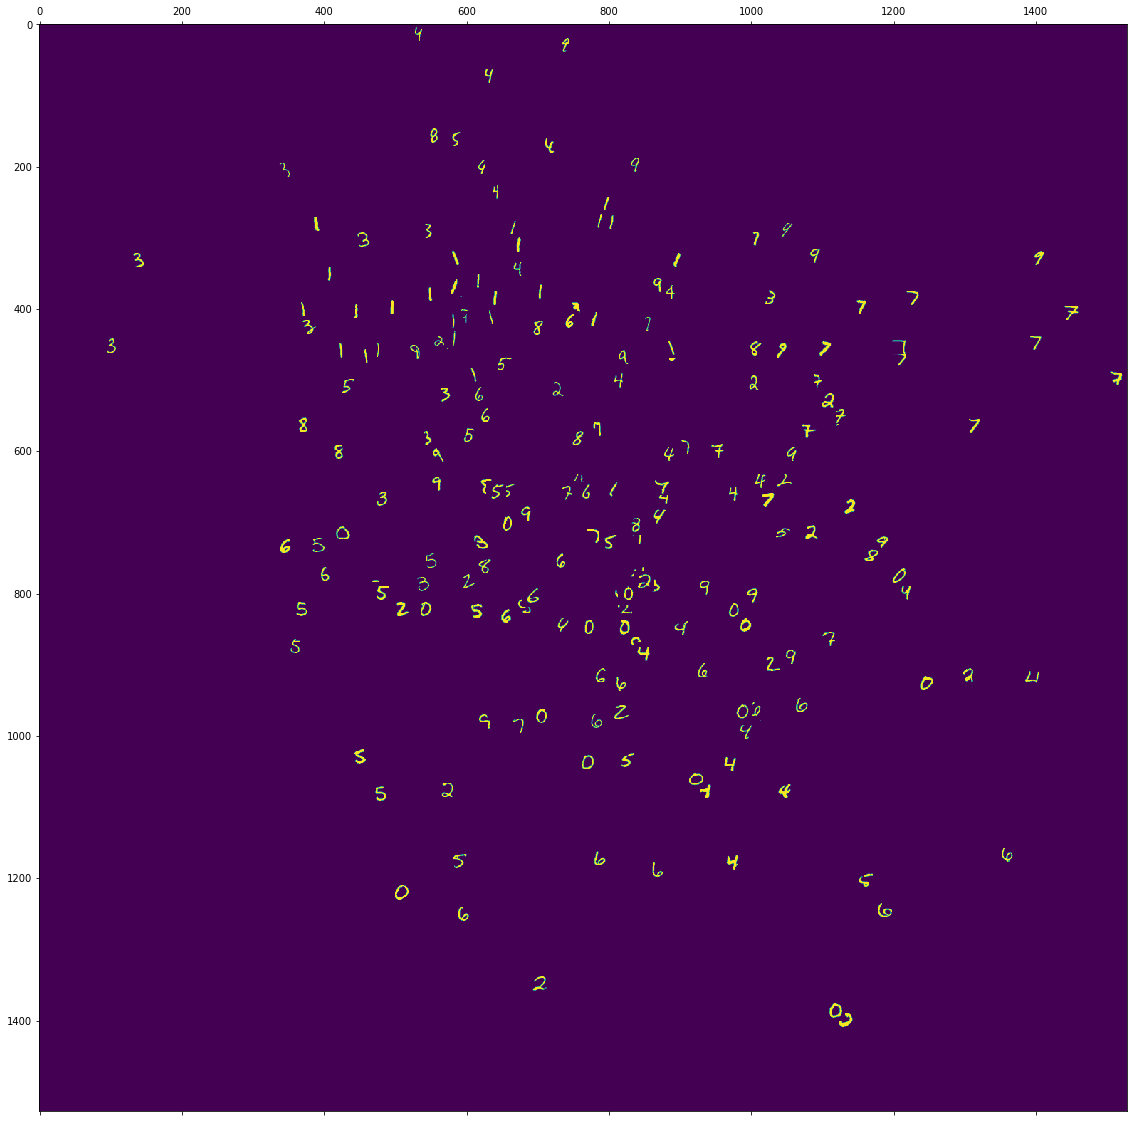

In [46]:
x = nn.transform(X_test[:n_samples_test])
make_viz(x, X_test[:n_samples_test].squeeze())

# Things to try: 
### Run for more `epochs` and larger `batch_size` (more training $\implies$ better embedding?)
### Try different values of `alpha` $\in [0.2, 1.0]$ and `learning_rate`
### We may observe the training fails to converge with large `learning_rate`

# Notes

### By the end, we have achieved a very good embedding with the NN
### Notice that the NN is *supervised*, in contrast to PCA and MDS
### We have produced a 2D embedding because that is nice for visualisation, but higher-dimensional embeddings are common in practice.

# Conclusions

### We have seen classic embedding algorithms

### We have seen the `scikit-learn` API and mimicked it in a modern neural model

### We have seen some Keras for creating neural networks

